In [2]:
# importing the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pylab as pl
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# reading the Excel File into a pandas df 
df = pd.read_excel('Garmin Fully Combined Table.xlsx')

In [3]:
df.isnull().sum()

Date                   0
Sleep Duration         4
Resting Heart Rate     2
Stress                 0
Body Battery           0
dtype: int64

In [4]:
#getting rid of any trailing or leading spaces 
df.columns = df.columns.str.strip()
#removing the spaces from the column names 
df = df.rename(columns={'Sleep Duration':'Sleep_Duration', 'Resting Heart Rate':'Resting_HR', 
                        'Body Battery':'Body_Battery', 'Date':'My_Date'})
#dropping missing values 
df = df.dropna()
#stripping the 'hrs' portion from sleep data
df['Sleep_Duration'] = df['Sleep_Duration'].str.replace(' hrs','')
df['Sleep_Duration'] = df['Sleep_Duration'].str.replace(':', '')

In [5]:
df['Body_Battery'].mean()

74.875

In [6]:
# I want to create a classification model to determine if my recovery will be over 75 based on the other three factors 
# first I must create a column containing either 1 or 0 depending if recovery is over 75

df['Class'] = (df['Body_Battery']> 75).astype(int)


In [7]:
# Checking to make sure it worked 
df.head()

,My_Date,Sleep_Duration,Resting_HR,Stress,Body_Battery,Class
1,2022-12-01,832,54.0,26,57,0
2,2022-12-02,812,50.0,28,98,1
4,2022-12-04,702,56.0,44,23,0
5,2022-12-05,1028,46.0,19,100,1
7,2022-12-07,930,46.0,24,100,1


In [8]:
y = pd.Series(df['Class'].to_numpy())
y.head()

0    0
1    1
2    0
3    1
4    1
dtype: int64

In [9]:
df_nd = df.drop('My_Date', axis=1)
df_nd_nc = df_nd.drop('Class', axis=1)
df_nd_nc.head()

,Sleep_Duration,Resting_HR,Stress,Body_Battery
1,832,54.0,26,57
2,812,50.0,28,98
4,702,56.0,44,23
5,1028,46.0,19,100
7,930,46.0,24,100


In [10]:
df_nd_nc = df_nd_nc.dropna()

In [11]:
df_nd_nc.dtypes

Sleep_Duration     object
Resting_HR        float64
Stress              int64
Body_Battery        int64
dtype: object

In [12]:
df_nd_nc['Resting_HR'].astype(int)
df_nd_nc['Sleep_Duration'].astype(int)
len(df_nd_nc)

55

# Logistic Regression 

Logistic regression is a model that aims to predict the class of a binomial variable based on data it is trained on. This scenario will use the model to try and predict when my recovery will be over 75 based on the other three variables. 

In [13]:
# standardizing the data and transforming it 
x = df_nd_nc
transform = preprocessing.StandardScaler()
x = transform.fit(x).transform(x)
len(x)

55

In [14]:
# x and Y are not the same length, but to use this model they must be 

min_length = min(len(x), len(y))
y = y[:min_length]
len(y)

55

In [15]:
# splitting the data into testing and training sets 
# using a 20% testing size 
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state = 1)
print('Training Set:', X_train.shape, Y_train.shape)
print('Testing Set:', X_test.shape, Y_test.shape)

Training Set: (44, 4) (44,)
Testing Set: (11, 4) (11,)


In [16]:
# creating a logistic regression model and a Gris Search CV 
# this will find the best paramaters for each 

parameters = {'C' : [0.01, 0.1, 1, 10],
             'penalty' : ['11', '12', 'elasticnet', 'none'],
             'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

lr = LogisticRegression()

logreg_cv = GridSearchCV(lr, parameters, cv=10, scoring='accuracy')
logreg_cv.fit(X_train, Y_train)

/Users/colbykeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/colbykeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/colbykeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/colbykeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/colbykeefe/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/colbykeefe/opt/ana

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'penalty': ['11', '12', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [17]:
print('tunes hyperparameters : (best parameters)' , logreg_cv.best_params_)
print('Accuracry:', logreg_cv.best_score_)

tunes hyperparameters : (best parameters) {'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}
Accuracry: 0.8300000000000001


In [18]:
# Calculating the accuracy of the test 

logreg_accuracy = logreg_cv.score(X_test, Y_test)
print('Test Data Score:', logreg_accuracy)


Test Data Score: 0.5454545454545454


In [19]:
# creating a confusion matrix 

def plot_confusion_matrix(y,y_predict):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); # annot = True to annotate cells 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True values')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['over 75', 'under 75']);ax.yaxis.set_ticklabels(['over 75', 'under 75'])
    plt.show()

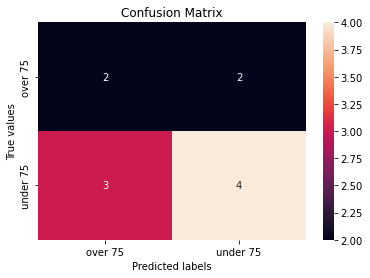

In [20]:
logreg_yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, logreg_yhat)

## Findings 

it is clear that this model is not very accurate, there are three false positives and 2 false negatives. 

# Support Vector Machine 

An SVM aims to find the hyperplane that separates the data points of different classes in a a way that maximizes margin. 

In [21]:
svm_parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'),
                 'C': np.logspace(-1, 3, 10),
                 'gamma' : np.logspace(-1, 3,10)}
svm = SVC()

In [22]:
svm_cv = GridSearchCV(svm, svm_parameters, cv = 10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03]),
                         'gamma': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

In [23]:
print('Best Parameters:', svm_cv.best_params_)
print('Accuracy:', svm_cv.best_score_)

Best Parameters: {'C': 0.774263682681127, 'gamma': 2.1544346900318834, 'kernel': 'rbf'}
Accuracy: 0.9400000000000001


In [24]:
# Calculatin the accuracy on the test data 
svm_accuracy = svm_cv.score(X_test, Y_test)
svm_accuracy

0.5454545454545454

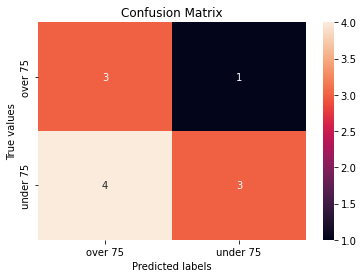

In [25]:
# Plotting the Confusion matrix 
svm_yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, svm_yhat)

## Findings 

This model predicted more false positives which is not a good sign. However, it predicted fewer False negatives and more true positives which is a good sign. 

# Decision Tree 

A decision tree model is a machine learning aglorithm that works by splitting the data into different subsets based on the most significant features 

In [26]:
# Setting the tree parameters 
tree_parameters = {'criterion': ['gini', 'entropy'],
                  'splitter' : ['best', 'random'],
                  'max_depth' : [2*n for n in range(1,10)],
                  'max_features' : ['auto', 'sqrt'], 
                  'min_samples_leaf': [2,4,6,8],
                  'min_samples_split': [2,5,10]}
tree = DecisionTreeClassifier()

In [27]:
# searching for the best parameters and fitting the training data on these parameters 
tree_cv = GridSearchCV(tree, tree_parameters, cv=10, error_score='raise')
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise', estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4, 6, 8],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [28]:
# printing the best parameters and accuracy 
print('Best Parameters:', tree_cv.best_params_)
print('Accuracy:', tree_cv.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy: 0.9400000000000001


In [29]:
# applying this to the testing set 
tree_accuracy = tree_cv.score(X_test, Y_test)
tree_accuracy

0.7272727272727273

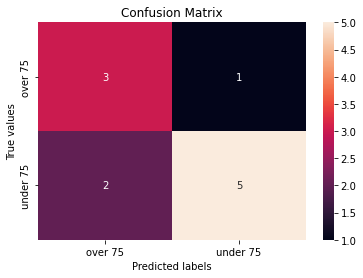

In [30]:
tree_yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, tree_yhat)

## Findings 

This model is the most accurate so far and it shows with the highest number of true negatives and tied with the SVM for the most true positives. It has the least false positives and false negatives. 

# K Nearest Neighbor 



In [31]:
K_parameters = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'p': [1,2]}

KNN = KNeighborsClassifier()

In [32]:
knn_cv = GridSearchCV(KNN, K_parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [33]:
print('Best Parameters', knn_cv.best_params_)
print('Accuracy', knn_cv.best_score_)

Best Parameters {'algorithm': 'auto', 'n_neighbors': 2, 'p': 1}
Accuracy 0.915


In [34]:
# Fitting the data to the testing set 
knn_accuracy = knn_cv.score(X_test, Y_test)
knn_accuracy

0.5454545454545454

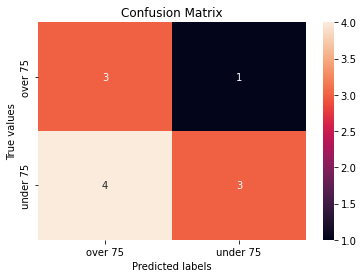

In [35]:
knn_yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, knn_yhat)

## Findings 

This model has the same accuracy as the SVM model on the training set. It produced the same number of TP, TN, FP, FN and was slightly less accurate on the training set. 

# Finding the method that performs the best 

In [39]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score 

# measures the score of the testing data set 
# Jaccard score measures the similartiy of the two sets of data 

jaccard_scores = [
    jaccard_score(Y_test, logreg_yhat, average='binary'),
    jaccard_score(Y_test, svm_yhat, average='binary'),
    jaccard_score(Y_test, tree_yhat, average='binary'),
    jaccard_score(Y_test, knn_yhat, average='binary'),
    
]

# F1 scores measures the accuracy of the classifier 

f1_scores = [
    f1_score(Y_test, logreg_yhat, average='binary'),
    f1_score(Y_test, svm_yhat, average='binary'),
    f1_score(Y_test, tree_yhat, average='binary'),
    f1_score(Y_test, knn_yhat, average='binary')
]

accuracy = [logreg_accuracy, svm_accuracy, tree_accuracy, knn_accuracy]

scores = pd.DataFrame(np.array([jaccard_scores, f1_scores, accuracy]),
                     index = ['jaccard_score', 'f1_scores', 'accuracy'],
                     columns = ['LogReg', 'SVM', 'Tree', 'KNN'])
scores

,LogReg,SVM,Tree,KNN
jaccard_score,0.444444,0.375000,0.625000,0.375000
f1_scores,0.615385,0.545455,0.769231,0.545455
accuracy,0.545455,0.545455,0.727273,0.545455


In [42]:
jaccard_scores2 = [
    jaccard_score(y, logreg_cv.predict(x), average='binary'),
    jaccard_score(y, svm_cv.predict(x), average='binary'),
    jaccard_score(y, tree_cv.predict(x), average='binary'),
    jaccard_score(y, knn_cv.predict(x), average='binary'),
    
]

# F1 scores measures the accuracy of the classifier 

f1_scores2 = [
    f1_score(y, logreg_cv.predict(x), average='binary'),
    f1_score(y, svm_cv.predict(x), average='binary'),
    f1_score(y, tree_cv.predict(x), average='binary'),
    f1_score(y, knn_cv.predict(x), average='binary')
]

accuracy2 = [logreg_cv.score(x,y), svm_cv.score(x,y), tree_cv.score(x,y), knn_cv.score(x,y)]

scores2 = pd.DataFrame(np.array([jaccard_scores2, f1_scores2, accuracy2]),
                     index = ['jaccard_score', 'f1_scores', 'accuracy'],
                     columns = ['LogReg', 'SVM', 'Tree', 'KNN'])
scores2

,LogReg,SVM,Tree,KNN
jaccard_score,0.714286,0.861111,0.789474,0.805556
f1_scores,0.833333,0.925373,0.882353,0.892308
accuracy,0.781818,0.909091,0.854545,0.872727
